# 準備

ドライブ構成  
chapter6/  
　　　　├ section6_3_recycleGAN_pytorch_face.ipynb (this file)  
　　　　└ datasets/  
　　　　　　　　　├fadg0/・・・(fadg0.zipを解答したもの）  
　　　　　　　　　└faks0/・・・(faks0.zipを解答したもの）  

In [ ]:
import google.colab.drive
google.colab.drive.mount('/content/gdrive')
!ls ./

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter6'

/content/gdrive/MyDrive/colab_GANBook


## 入力画像の確認

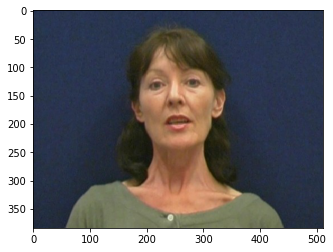

In [ ]:
import matplotlib.pyplot as plt

# ドメインAの学習データ
img = plt.imread('datasets/fadg0/video/head/001')
plt.imshow(img)

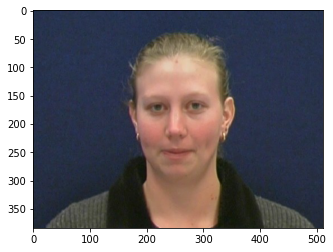

In [ ]:
# ドメインBの学習データ
img = plt.imread('datasets/faks0/video/head/001')
plt.imshow(img)

## ライブラリのインストール

In [ ]:
!pip install torch>=0.4.1
!pip install torchvision>=0.2.1
!pip install dominate>=2.3.1
!pip install visdom>=0.1.8.
!pip install tensorboard
!pip install tensorboardX

## インポート

In [ ]:
import glob
import random
import os
import numpy as np
import time
import datetime
import sys

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch
from visdom import Visdom

import itertools
from PIL import Image

In [ ]:
# ドメインAとドメインBの画像データセット生成クラス
class FaceDatasetSequence(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train', 
                 files_A='fadg0/video/', files_B='faks0/video/', skip=0):
        """
        self.files_A: 同じsequence の中では最後の(skip + 1)*2個を除いたものを集める
        params: skipはsequentialなデータを作る際の間引き数. skip=1 で1飛ばしのデータとなる。
        1) get directories in directory A, files in directory B
        2) in loop, append files to file_list except for last (skip + 1)*2 sequence

        """
        self.skip = skip
        self.remove_num = (skip + 1) * 2
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        dir_A = os.listdir(path=os.path.join(root, files_A))
        dir_B = os.listdir(path=os.path.join(root, files_B))
        self.files_A = []
        self.files_B = []
        for dir1 in dir_A:
            all_files = sorted(glob.glob(os.path.join(root, files_A, dir1 + '/*')))
            self.files_A += all_files[:- self.remove_num] # 最後から(skip + 1)*2つは削除
        for dir1 in dir_B:
            all_files = sorted(glob.glob(os.path.join(root, files_B, dir1 + '/*')))
            self.files_B += all_files[:- self.remove_num] # 最後から(skip + 1)*2つは削除
        print("len(self.files_A):{}, len(self.files_B):{}".format(len(self.files_A), len(self.files_B)))
        self.count = 1234

    def __getitem__(self, index):
        seed = self.count
        file_A1 = self.files_A[index % len(self.files_A)]
        item_A1, item_A2, item_A3 = self.get_sequential_data(file_A1, seed)
        if self.unaligned:
            num_tmp = np.random.randint(0, len(self.files_B) - 1)
            file_B1 = self.files_B[num_tmp]

        else:
            file_B1 = self.files_B[index % len(self.files_B)]
        item_B1, item_B2, item_B3 = self.get_sequential_data(file_B1, seed+1)
        self.count += 1
        return {'A1': item_A1, 'A2': item_A2, 'A3': item_A3, 'B1': item_B1, 'B2': item_B2, 'B3': item_B3}
        

    def get_sequential_data(self, file1, seed):
        dir_name, file_num = file1.rsplit('/', 1)
        file2 = os.path.join(dir_name, '{:0=3}'.format(int(file_num) + self.skip))
        file3 = os.path.join(dir_name, '{:0=3}'.format(int(file_num) + self.skip * 2))
        random.seed(seed)
        item1 = self.transform(Image.open(file1).convert('RGB'))
        random.seed(seed)
        item2 = self.transform(Image.open(file2).convert('RGB'))
        random.seed(seed)
        item3 = self.transform(Image.open(file3).convert('RGB'))
        return item1, item2, item3

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

# ネットワーク定義

## Residual Block

In [ ]:
# ResidualBlockの定義
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)

## 生成器

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


## 識別器

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

## 生成画像のバッファ

In [ ]:
# 過去の生成データ(50iter分)を保持しておく
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            #
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [ ]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

## 予測器

In [ ]:
class ConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvUnit(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = ConvUnit(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Predictor(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(Predictor, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.inc = ConvUnit(input_nc, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, output_nc)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        out = self.tanh(logits)
        return out

In [ ]:
!mkdir -p output
!ls output

# 学習

## パラメータ設定

In [ ]:
class Opts():
    def __init__(self):
        self.start_epoch = 0
        self.n_epochs = 40
        self.batch_size = 1
        self.dataroot = 'datasets/'
        self.lr = 0.0002
        self.decay_epoch = 200
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cpu = False
        self.n_cpu = 8
        self.device_name = "cuda:0"
        self.device = torch.device(self.device_name)
        self.load_weight = False
        self.log_base_name = 'train11'
        self.model_load_path = 'output/recycle/train10/output_model/'
        self.file_a_dir = 'fadg0/video/'
        self.file_b_dir = 'faks0/video/'
        self.id_loss_rate = 5.0
        self.gan_loss_rate = 5.0
        self.recy_loss_rate = 10.0
        self.recu_loss_rate = 10.0
        self.skip = 2

opt = Opts()

## TensorboardでのLoss確認

In [ ]:
from torch.utils.tensorboard import SummaryWriter
if not os.path.isdir('./logs'):
    os.mkdir('./logs')
if not os.path.isdir('./logs/recycle'):
    os.mkdir('./logs/recycle')
log_dir = os.path.join('./logs/recycle/', opt.log_base_name)
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
%load_ext tensorboard
%tensorboard --logdir './logs/recycle/train11'

## 画像保存・モデル保存のための処理

In [ ]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().detach().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

def tensor2image_ver2(tensor):
    image = 127.5*(tensor[0].cpu().float().detach().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    image = image.astype(np.uint8).transpose(1,2,0)
    return image

def save_img(img_uint8_real, img_uint8_fake, img_uint8_rec, save_f_path):
    img_uint8 = np.concatenate((img_uint8_real, img_uint8_fake, img_uint8_rec), axis=1)
    img_pil = Image.fromarray(img_uint8)
    img_pil.save(save_f_path)

def save_several_img(img_tuple, save_f_path):
    img_uint8 = np.concatenate(img_tuple, axis=1)
    img_pil = Image.fromarray(img_uint8)
    img_pil.save(save_f_path)

if not os.path.isdir('./output/recycle'):
    os.mkdir('./output/recycle/')
if not os.path.isdir(os.path.join('./output/recycle',opt.log_base_name)):
    os.mkdir(os.path.join('./output/recycle', opt.log_base_name))
if not os.path.isdir(os.path.join('./output/recycle' ,opt.log_base_name, 'output_img')):
    os.mkdir(os.path.join('./output/recycle' ,opt.log_base_name, 'output_img'))
if not os.path.isdir(os.path.join('./output/recycle' ,opt.log_base_name, 'output_model')):
    os.mkdir(os.path.join('./output/recycle' ,opt.log_base_name, 'output_model'))

NameError: ignored

## ネットワーク呼び出し

In [ ]:

# 生成器
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)

# 識別器
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

# 予測器 ---------------------------- recycle -------------------------------------------------
netP_A = Predictor(opt.input_nc*2, opt.input_nc)
netP_B = Predictor(opt.output_nc*2, opt.output_nc)

# GPU
if not opt.cpu:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()
    netP_A.cuda() # predictor
    netP_B.cuda() # predictor

# 重みパラメータ初期化
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# 保存したモデルのロード
if opt.load_weight is True:
    netG_A2B.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netG_A2B.pth"), map_location="cuda:0"), strict=False)
    netG_B2A.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netG_B2A.pth"), map_location="cuda:0"), strict=False)
    netD_A.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netD_A.pth"), map_location="cuda:0"), strict=False)
    netD_B.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netD_B.pth"), map_location="cuda:0"), strict=False)
    netP_A.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netP_A.pth"), map_location="cuda:0"), strict=False) # predictor
    netP_B.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netP_B.pth"), map_location="cuda:0"), strict=False) # predictor

# 損失関数
criterion_GAN = torch.nn.MSELoss()
criterion_recycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
criterion_recurrent = torch.nn.L1Loss() # predictor


# Optimizers & LR schedulers
optimizer_PG = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters(), netP_A.parameters(),
                                               netP_B.parameters()), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_PG = torch.optim.lr_scheduler.LambdaLR(optimizer_PG, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)

# 入出力メモリ確保
Tensor = torch.cuda.FloatTensor if not opt.cpu else torch.Tensor
input_A1 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_A2 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_A3 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_B1 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
input_B2 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
input_B3 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batch_size).fill_(0.0), requires_grad=False)

# 過去データ分のメモリ確保
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# データローダー
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
# dataloader = DataLoader(FaceDatasetSequence(opt.dataroot, transforms_=transforms_, unaligned=True, 
dataloader = DataLoader(FaceDatasetSequence(opt.dataroot, transforms_=transforms_, unaligned=False, 
                                            files_A=opt.file_a_dir, files_B=opt.file_b_dir, skip=opt.skip), 
                        batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)

print("num dataloader= {}".format(len(dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  del sys.path[0]


len(self.files_A):2551, len(self.files_B):1969
num dataloader= 2551


In [ ]:
def save_loss(train_info, batches_done):
    """
    lossの保存
    """
    for k, v in train_info.items():
        writer.add_scalar(k, v, batches_done)


## 学習の開始

In [ ]:

for epoch in range(opt.start_epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):
        # モデルの入力
        real_A1 = Variable(input_A1.copy_(batch['A1']))
        real_A2 = Variable(input_A2.copy_(batch['A2']))
        real_A3 = Variable(input_A3.copy_(batch['A3']))

        real_B1 = Variable(input_B1.copy_(batch['B1']))
        real_B2 = Variable(input_B2.copy_(batch['B2']))
        real_B3 = Variable(input_B3.copy_(batch['B3']))

        ##### 生成器A2B、B2Aの処理 #####
        optimizer_PG.zero_grad()

        # 同一性損失の計算（Identity loss)
        # G_A2B(B)はBと一致
        same_B1 = netG_A2B(real_B1)
        loss_identity_B = criterion_identity(same_B1, real_B1)*opt.id_loss_rate
        # G_B2A(A)はAと一致
        same_A1 = netG_B2A(real_A1)
        loss_identity_A = criterion_identity(same_A1, real_A1)*opt.id_loss_rate

        # 敵対的損失（GAN loss）
        fake_B1 = netG_A2B(real_A1)
        pred_fake_B1 = netD_B(fake_B1)
        loss_GAN_A2B1 = criterion_GAN(pred_fake_B1, target_real)*opt.gan_loss_rate

        fake_B2 = netG_A2B(real_A2)
        pred_fake_B2 = netD_B(fake_B2)
        loss_GAN_A2B2 = criterion_GAN(pred_fake_B2, target_real)*opt.gan_loss_rate

        fake_B3 = netG_A2B(real_A3)
        pred_fake_B3 = netD_B(fake_B3)
        loss_GAN_A2B3 = criterion_GAN(pred_fake_B3, target_real)*opt.gan_loss_rate

        fake_A1 = netG_B2A(real_B1)
        pred_fake_A1 = netD_A(fake_A1)
        loss_GAN_B2A1 = criterion_GAN(pred_fake_A1, target_real)*opt.gan_loss_rate

        fake_A2 = netG_B2A(real_B2)
        pred_fake_A2 = netD_A(fake_A2)
        loss_GAN_B2A2 = criterion_GAN(pred_fake_A2, target_real)*opt.gan_loss_rate

        fake_A3 = netG_B2A(real_B3)
        pred_fake_A3 = netD_A(fake_A3)
        loss_GAN_B2A3 = criterion_GAN(pred_fake_A3, target_real)*opt.gan_loss_rate

        # サイクル一貫性損失（Cycle-consistency loss）
        fake_B12 = torch.cat((fake_B1, fake_B2), dim=1)
        fake_B3_pred = netP_B(fake_B12)
        recovered_A3 = netG_B2A(fake_B3_pred)
        loss_recycle_ABA = criterion_recycle(recovered_A3, real_A3)*opt.recy_loss_rate

        fake_A12 = torch.cat((fake_A1, fake_A2), dim=1)
        fake_A3_pred = netP_A(fake_A12)
        recovered_B3 = netG_A2B(fake_A3_pred)
        loss_recycle_BAB = criterion_recycle(recovered_B3, real_B3)*opt.recy_loss_rate

        # Recurrent loss
        real_A12 = torch.cat((real_A1, real_A2), dim=1)
        pred_A3 = netP_A(real_A12)
        loss_recurrent_A = criterion_recurrent(pred_A3, real_A3)*opt.recu_loss_rate

        real_B12 = torch.cat((real_B1, real_B2), dim=1)
        pred_B3 = netP_B(real_B12)
        loss_recurrent_B = criterion_recurrent(pred_B3, real_B3)*opt.recu_loss_rate


        # 生成器の合計損失関数（Total loss）
        loss_PG = loss_identity_A + loss_identity_B \
                + loss_GAN_A2B1 + loss_GAN_A2B2 + loss_GAN_A2B3 + loss_GAN_B2A1 + loss_GAN_B2A2 + loss_GAN_B2A3 \
                + loss_recycle_ABA + loss_recycle_BAB \
                + loss_recurrent_A + loss_recurrent_B
        loss_PG.backward()
        
        optimizer_PG.step()

        # 保存用画像のための処理
        fake_A1_clone = fake_A1.clone()
        fake_B1_clone = fake_B1.clone()
        fake_A2_clone = fake_A2.clone()
        fake_B2_clone = fake_B2.clone()
        fake_A3_clone = fake_A3.clone()
        fake_B3_clone = fake_B3.clone()
        real_A1_clone = real_A1.clone()
        real_B1_clone = real_B1.clone()
        real_A2_clone = real_A2.clone()
        real_B2_clone = real_B2.clone()
        real_A3_clone = real_A3.clone()
        real_B3_clone = real_B3.clone()
        recovered_A1 = netG_B2A(fake_B1_clone)
        recovered_B1 = netG_A2B(fake_A1_clone)

        ##### ドメインAの識別器 #####
        optimizer_D_A.zero_grad()

        # ドメインAの本物画像の識別結果（Real loss）
        pred_real_A1 = netD_A(real_A1)
        loss_D_real_A1 = criterion_GAN(pred_real_A1, target_real)
        pred_real_A2 = netD_A(real_A2)
        loss_D_real_A2 = criterion_GAN(pred_real_A2, target_real)
        pred_real_A3 = netD_A(real_A3)
        loss_D_real_A3 = criterion_GAN(pred_real_A3, target_real)

        # ドメインAの生成画像の識別結果（Fake loss）
        fake_A1 = fake_A_buffer.push_and_pop(fake_A1)
        pred_fake_A1 = netD_A(fake_A1.detach())
        loss_D_fake_A1 = criterion_GAN(pred_fake_A1, target_fake)
        
        fake_A2 = fake_A_buffer.push_and_pop(fake_A2)
        pred_fake_A2 = netD_A(fake_A2.detach())
        loss_D_fake_A2 = criterion_GAN(pred_fake_A2, target_fake)
        
        fake_A3 = fake_A_buffer.push_and_pop(fake_A3)
        pred_fake_A3 = netD_A(fake_A3.detach())
        loss_D_fake_A3 = criterion_GAN(pred_fake_A3, target_fake)

        # 識別器（ドメインA）の合計損失（Total loss）
        loss_D_A = (loss_D_real_A1 + loss_D_real_A2 + loss_D_real_A3 + loss_D_fake_A1 + loss_D_fake_A2 + loss_D_fake_A3)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()

        ##### ドメインBの識別器 #####
        optimizer_D_B.zero_grad()

        # ドメインBの本物画像の識別結果（Real loss）
        pred_real_B1 = netD_B(real_B1)
        loss_D_real_B1 = criterion_GAN(pred_real_B1, target_real)
        pred_real_B2 = netD_B(real_B2)
        loss_D_real_B2 = criterion_GAN(pred_real_B2, target_real)
        pred_real_B3 = netD_B(real_B3)
        loss_D_real_B3 = criterion_GAN(pred_real_B3, target_real)
        
        # ドメインBの生成画像の識別結果（Fake loss）
        fake_B1 = fake_A_buffer.push_and_pop(fake_B1)
        pred_fake_B1 = netD_B(fake_B1.detach())
        loss_D_fake_B1 = criterion_GAN(pred_fake_B1, target_fake)

        fake_B2 = fake_A_buffer.push_and_pop(fake_B2)
        pred_fake_B2 = netD_B(fake_B2.detach())
        loss_D_fake_B2 = criterion_GAN(pred_fake_B2, target_fake)

        fake_B3 = fake_A_buffer.push_and_pop(fake_B3)
        pred_fake_B3 = netD_B(fake_B3.detach())
        loss_D_fake_B3 = criterion_GAN(pred_fake_B3, target_fake)

        # 識別器（ドメインB）の合計損失（Total loss）
        loss_D_B = (loss_D_real_B1 + loss_D_real_B2 + loss_D_real_B3 + loss_D_fake_B1 + loss_D_fake_B2 + loss_D_fake_B3)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        if i % 20 == 0:
            print('Epoch[{}]({}/{}) loss_PG: {:.3f} loss_G_identity: {:.3f} loss_G_GAN: {:.3} loss_G_recycle: {:.3f} loss_D: {:.3f}'.format(
                epoch, i, len(dataloader), loss_PG, (loss_identity_A + loss_identity_B),
                (loss_GAN_A2B1+loss_GAN_A2B2+loss_GAN_A2B3+loss_GAN_B2A1+loss_GAN_B2A2+loss_GAN_B2A3),
                (loss_recycle_ABA + loss_recycle_BAB), (loss_D_A + loss_D_B)))
            print( 'loss_recurrent: {:.3f} loss_D_A_fake: {:.3f} loss_D_A_real: {:.3f} loss_D_B_fake: {:.3f} loss_D_B_real: {:.3f}'.format(
                    (loss_recurrent_A + loss_recurrent_B),
                    (loss_D_fake_A1 + loss_D_fake_A2 + loss_D_fake_A3), (loss_D_real_A1 + loss_D_real_A2 + loss_D_real_A3),
                    (loss_D_fake_B1 + loss_D_fake_B2 + loss_D_fake_B3), (loss_D_real_B1 + loss_D_real_B2 + loss_D_real_B3)))

        train_info = {
            'epoch': epoch, 
            'batch_num': i, 
            'lossG': loss_PG.item(),
            'lossG_identity': (loss_identity_A.item() + loss_identity_B.item()),
            'lossG_GAN': (loss_GAN_A2B1.item()+loss_GAN_A2B2.item()+loss_GAN_A2B3.item()+loss_GAN_B2A1.item()+loss_GAN_B2A2.item()+loss_GAN_B2A3.item()),
            'lossG_recycle': (loss_recycle_ABA.item() + loss_recycle_BAB.item()),
            'lossG_recurrent': (loss_recurrent_A.item() + loss_recurrent_B.item()),
            'lossD': (loss_D_fake_A1.item() + loss_D_fake_A2.item() + loss_D_fake_A3.item()
                      + loss_D_real_A1.item() + loss_D_real_A2.item() + loss_D_real_A3.item()
                      + loss_D_fake_B1.item() + loss_D_fake_B2.item() + loss_D_fake_B3.item()
                      +loss_D_real_B1.item() + loss_D_real_B2.item() + loss_D_real_B3.item()), 
            }

        batches_done = (epoch - 1) * len(dataloader) + i
        save_loss(train_info, batches_done)

        if i == 0:
            # 生成画像の保存
            realb1_img_uint8 = tensor2image_ver2(real_B1_clone)
            fakea1_img_uint8 = tensor2image_ver2(fake_A1_clone)
            rec_b1_img_uint8 = tensor2image_ver2(recovered_B1)
            save_several_img((realb1_img_uint8, fakea1_img_uint8, rec_b1_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_BAB_e{}.png'.format(epoch)))

            reala1_img_uint8 = tensor2image_ver2(real_A1_clone)
            fakeb1_img_uint8 = tensor2image_ver2(fake_B1_clone)
            rec_a1_img_uint8 = tensor2image_ver2(recovered_A1)
            save_several_img((reala1_img_uint8, fakeb1_img_uint8, rec_a1_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_ABA_e{}.png'.format(epoch)))
            
            same_a1_img_uint8 = tensor2image_ver2(same_A1)
            save_several_img((reala1_img_uint8, same_a1_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_ide_A_e{}.png'.format(epoch)))

            same_b1_img_uint8 = tensor2image_ver2(same_B1)
            save_several_img((realb1_img_uint8, same_b1_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_ideB_e{}.png'.format(epoch)))


            pred_A3_img_uint8 = tensor2image_ver2(pred_A3)
            real_A1_img_uint8 = tensor2image_ver2(real_A1_clone)
            real_A2_img_uint8 = tensor2image_ver2(real_A2_clone)
            real_A3_img_uint8 = tensor2image_ver2(real_A3_clone)
            save_several_img((real_A1_img_uint8, real_A2_img_uint8, pred_A3_img_uint8, real_A3_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_predA_e{}.png'.format(epoch)))

            pred_B3_img_uint8 = tensor2image_ver2(pred_B3)
            real_B1_img_uint8 = tensor2image_ver2(real_B1_clone)
            real_B2_img_uint8 = tensor2image_ver2(real_B2_clone)
            real_B3_img_uint8 = tensor2image_ver2(real_B3_clone)
            save_several_img((real_B1_img_uint8, real_B2_img_uint8, pred_B3_img_uint8, real_B3_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_predB_e{}.png'.format(epoch)))

            fp_A3_img_uint8 = tensor2image_ver2(fake_A3_pred)
            rec_B3_img_uint8 = tensor2image_ver2(recovered_B3)
            save_several_img((realb1_img_uint8, fakea1_img_uint8, fp_A3_img_uint8, rec_B3_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_BAPB_e{}.png'.format(epoch)))

            fp_B3_img_uint8 = tensor2image_ver2(fake_B3_pred)
            rec_A3_img_uint8 = tensor2image_ver2(recovered_A3)
            save_several_img((reala1_img_uint8, fakeb1_img_uint8, fp_B3_img_uint8, rec_A3_img_uint8),
                     os.path.join('output/recycle', opt.log_base_name, 'output_img/img_ABPA_e{}.png'.format(epoch)))

    # Update learning rates
    lr_scheduler_PG.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), os.path.join('output/recycle/', opt.log_base_name, 'output_model/netG_A2B.pth'))
    torch.save(netG_B2A.state_dict(), os.path.join('output/recycle/', opt.log_base_name, 'output_model/netG_B2A.pth'))
    torch.save(netD_A.state_dict(), os.path.join('output/recycle/', opt.log_base_name, 'output_model/netD_A.pth'))
    torch.save(netD_B.state_dict(), os.path.join('output/recycle/', opt.log_base_name, 'output_model/netD_B.pth'))
    torch.save(netP_A.state_dict(), os.path.join('output/recycle/', opt.log_base_name, 'output_model/netP_A.pth')) # predictor
    torch.save(netP_B.state_dict(), os.path.join('output/recycle/', opt.log_base_name, 'output_model/netP_B.pth')) # predictor

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch[0](0/2551) loss_PG: 17.153 loss_G_identity: 0.332 loss_G_GAN: 15.2 loss_G_recycle: 1.079 loss_D: 0.914
loss_recurrent: 0.521 loss_D_A_fake: 0.006 loss_D_A_real: 0.189 loss_D_B_fake: 1.421 loss_D_B_real: 0.211
Epoch[0](20/2551) loss_PG: 13.395 loss_G_identity: 0.259 loss_G_GAN: 12.1 loss_G_recycle: 0.702 loss_D: 1.212
loss_recurrent: 0.371 loss_D_A_fake: 0.200 loss_D_A_real: 1.798 loss_D_B_fake: 0.406 loss_D_B_real: 0.021
Epoch[0](40/2551) loss_PG: 12.802 loss_G_identity: 0.267 loss_G_GAN: 11.3 loss_G_recycle: 0.801 loss_D: 1.417
loss_recurrent: 0.474 loss_D_A_fake: 0.630 loss_D_A_real: 0.014 loss_D_B_fake: 0.210 loss_D_B_real: 1.981
Epoch[0](60/2551) loss_PG: 9.461 loss_G_identity: 0.335 loss_G_GAN: 7.39 loss_G_recycle: 1.018 loss_D: 0.939
loss_recurrent: 0.719 loss_D_A_fake: 0.419 loss_D_A_real: 0.096 loss_D_B_fake: 0.944 loss_D_B_real: 0.419
Epoch[0](80/2551) loss_PG: 5.765 loss_G_identity: 0.294 loss_G_GAN: 4.11 loss_G_recycle: 0.858 loss_D: 0.701
loss_recurrent: 0.500 loss_D_

KeyboardInterrupt: ignored

In [ ]:
!ls output

netD_A.pth  netD_B.pth	netG_A2B.pth  netG_B2A.pth


# 画像生成テスト

## パラメータ設定

In [ ]:

class Opts_test():
    def __init__(self):
        self.batch_size = 1
        self.dataroot = 'datasets/'
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cpu = False
        self.n_cpu = 8
        self.device_name = "cuda:0"
        self.device = torch.device(self.device_name)
        self.load_weight = True
        self.cuda = True
        self.model_load_path = 'output/recycle/train11/output_model/'
        self.log_base_name = 'test01'
        self.file_a_dir = 'fadg0/video/'
        self.file_b_dir = 'faks0/video/'
        self.skip = 2

opt2 = Opts_test()


## ネットワーク呼び出し

In [ ]:

# 生成器G
netG_A2B = Generator(opt2.input_nc, opt2.output_nc)
netG_B2A = Generator(opt2.output_nc, opt2.input_nc)

# 予測器 
netP_A = Predictor(opt.input_nc*2, opt.input_nc)
netP_B = Predictor(opt.output_nc*2, opt.output_nc)


# CUDA
if opt2.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netP_A.cuda() # predictor
    netP_B.cuda() # predictor

# Load state dicts
netG_A2B.load_state_dict(torch.load(os.path.join(opt2.model_load_path, 'netG_A2B.pth')))
netG_B2A.load_state_dict(torch.load(os.path.join(opt2.model_load_path, 'netG_B2A.pth')))
netP_A.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netP_A.pth"), map_location="cuda:0"), strict=False) # predictor
netP_B.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netP_B.pth"), map_location="cuda:0"), strict=False) # predictor

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()
netP_A.eval()
netP_B.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt2.cuda else torch.Tensor
input_A1 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_A2 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_A3 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_B1 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
input_B2 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
input_B3 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [transforms.Resize(int(opt2.size*1.0), Image.BICUBIC), 
                transforms.RandomCrop(opt2.size), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(FaceDatasetSequence(opt.dataroot, transforms_=transforms_, unaligned=False, 
                                            files_A=opt2.file_a_dir, files_B=opt2.file_b_dir, skip=opt.skip), 
                        batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)


# 出力用フォルダ生成
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name)):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name))
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name, 'output_img')):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name, 'output_img'))
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name, 'output_img/A')):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name, 'output_img/A'))
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name, 'output_img/B')):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name, 'output_img/B'))

len(self.files_A):2551, len(self.files_B):1969


## テスト実行

In [ ]:
##### 生成器Gによる画像生成　#####
from torchvision.utils import save_image

num_create = 100

for i, batch in enumerate(dataloader):
    # Set model input
    real_A1 = Variable(input_A1.copy_(batch['A1']))
    real_A2 = Variable(input_A2.copy_(batch['A2']))
    real_A3 = Variable(input_A3.copy_(batch['A3']))

    real_B1 = Variable(input_B1.copy_(batch['B1']))
    real_B2 = Variable(input_B2.copy_(batch['B2']))
    real_B3 = Variable(input_B3.copy_(batch['B3']))

    # Generate fake image
    fake_B1 = netG_A2B(real_A1)
    fake_B2 = netG_A2B(real_A2)
    fake_B3 = netG_A2B(real_A3)

    fake_A1 = netG_B2A(real_B1)
    fake_A2 = netG_B2A(real_B2)
    fake_A3 = netG_B2A(real_B3)

    # Predict next step
    fake_B12 = torch.cat((fake_B1, fake_B2), dim=1)
    fake_B3_pred = netP_B(fake_B12)

    fake_A12 = torch.cat((fake_A1, fake_A2), dim=1)
    fake_A3_pred = netP_B(fake_A12)

    # Calculate the average of fake and pred
    fake_B3_ave = (fake_B3 + fake_B3_pred) / 2.
    fake_A3_ave = (fake_A3 + fake_A3_pred) / 2.


    real_A1_out = 0.5*(real_A1 + 1.0)
    real_A2_out = 0.5*(real_A2 + 1.0)
    real_A3_out = 0.5*(real_A3 + 1.0)

    real_B1_out = 0.5*(real_B1 + 1.0)
    real_B2_out = 0.5*(real_B2 + 1.0)
    real_B3_out = 0.5*(real_B3 + 1.0)

    fake_A3_ave_out = 0.5*(fake_A3_ave + 1.0)
    fake_B3_ave_out = 0.5*(fake_B3_ave + 1.0)

    out_img1 = torch.cat([real_A3_out, fake_B3_ave_out], dim=2)
    out_img2 = torch.cat([real_B3_out, fake_A3_ave_out], dim=2)

    # Save image files
    save_image(out_img1, os.path.join('output/recycle/', opt2.log_base_name, 'output_img/A/%04d.png' % (i+1)))
    save_image(out_img2, os.path.join('output/recycle/', opt2.log_base_name, 'output_img/B/%04d.png' % (i+1)))

    if i > num_create:
        break


## 生成画像の表示

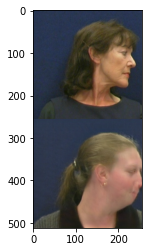

In [ ]:
# A->Bの生成画像
import matplotlib.pyplot as plt
img = plt.imread(os.path.join('output/recycle/', opt2.log_base_name, 'output_img/A/0001.png'))
plt.imshow(img)

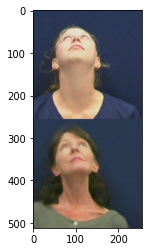

In [ ]:
# B->Aの生成画像
img = plt.imread(os.path.join('output/recycle/', opt2.log_base_name, 'output_img/B/0001.png'))
plt.imshow(img)

# ビデオ生成テスト

## 動画出力用のデータセット生成

In [ ]:
# 動画出力用のデータセット生成クラス
class FaceDatasetVideo(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train', 
                 files='fadg0/video/head', skip=2):
        self.skip = skip
        self.remove_num = (skip + 1) * 2
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        all_files = sorted(glob.glob(os.path.join(root, files) + '/*'))
        self.files = all_files[:-self.remove_num]

    def __getitem__(self, index):
        file = self.files[index % len(self.files)]
        seed = 1234
        item_1, item_2, item_3 = self.get_sequential_data(file, seed)
        return {'1': item_1, '2': item_2, '3' : item_3}

    def get_sequential_data(self, file1, seed):
        dir_name, file_num = file1.rsplit('/', 1)
        file2 = os.path.join(dir_name, '{:0=3}'.format(int(file_num) + self.skip))
        file3 = os.path.join(dir_name, '{:0=3}'.format(int(file_num) + self.skip * 2))
        random.seed(seed)
        item1 = self.transform(Image.open(file1).convert('RGB'))
        random.seed(seed)
        item2 = self.transform(Image.open(file2).convert('RGB'))
        random.seed(seed)
        item3 = self.transform(Image.open(file3).convert('RGB'))
        return item1, item2, item3
        
    def __len__(self):
        return len(self.files)

## 動画出力の処理

In [ ]:
# 動画出力用フォルダの生成
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name, 'output_video')):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name, 'output_video'))
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name, 'output_video/A2B')):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name, 'output_video/A2B'))
if not os.path.exists(os.path.join('output/recycle', opt2.log_base_name, 'output_video/B2A')):
    os.makedirs(os.path.join('output/recycle', opt2.log_base_name, 'output_video/B2A'))



# 動画のパラメータを設定
import cv2
in_video_w = 256*2
in_video_h = 256
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')

def make_video(output_video_path, input_dir_path, domain, skip=2):
    video = cv2.VideoWriter(output_video_path, fourcc, 10.0, (in_video_w, in_video_h))

    # ネットワーク呼び出し
    # 生成器G
    netG_A2B = Generator(opt2.input_nc, opt2.output_nc)
    netG_B2A = Generator(opt2.output_nc, opt2.input_nc)

    # 予測器 
    netP_A = Predictor(opt.input_nc*2, opt.input_nc)
    netP_B = Predictor(opt.output_nc*2, opt.output_nc)

    # CUDA
    if opt2.cuda:
        netG_A2B.cuda()
        netG_B2A.cuda()
        netP_A.cuda() # predictor
        netP_B.cuda() # predictor

    # Load state dicts
    netG_A2B.load_state_dict(torch.load(os.path.join(opt2.model_load_path, 'netG_A2B.pth')))
    netG_B2A.load_state_dict(torch.load(os.path.join(opt2.model_load_path, 'netG_B2A.pth')))
    netP_A.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netP_A.pth"), map_location="cuda:0"), strict=False) # predictor
    netP_B.load_state_dict(torch.load(os.path.join(opt.model_load_path, "netP_B.pth"), map_location="cuda:0"), strict=False) # predictor

    # Set model's test mode
    netG_A2B.eval()
    netG_B2A.eval()
    netP_A.eval()
    netP_B.eval()

    # Inputs & targets memory allocation
    Tensor = torch.cuda.FloatTensor if opt2.cuda else torch.Tensor
    input_A1 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
    input_A2 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
    input_A3 = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
    input_B1 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
    input_B2 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
    input_B3 = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)


    # Dataset loader
    transforms_ = [transforms.Resize(int(opt2.size*1.0), Image.BICUBIC), 
                    transforms.CenterCrop(opt2.size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
    dataloader = DataLoader(FaceDatasetVideo(opt2.dataroot, transforms_=transforms_, mode='test',
                            files=input_dir_path, skip=skip), 
                            batch_size=opt2.batch_size, shuffle=False, num_workers=opt2.n_cpu)
    
    ##### 生成器Gによる動画生成　#####
    for i, batch in enumerate(dataloader):
        if domain == 'A':
            # Set model input
            real_A1 = Variable(input_A1.copy_(batch['1']))
            real_A2 = Variable(input_A2.copy_(batch['2']))
            real_A3 = Variable(input_A3.copy_(batch['3']))

            # Generate output
            fake_B1 = netG_A2B(real_A1)
            fake_B2 = netG_A2B(real_A2)
            fake_B3 = netG_A2B(real_A3)

            fake_B12 = torch.cat((fake_B1, fake_B2), dim=1)
            fake_B3_pred = netP_B(fake_B12)

            # Calculate the average of fake and pred
            fake_B3_ave = (fake_B3 + fake_B3_pred) / 2.

            out_img1 = torch.cat([real_A3, fake_B3_ave], dim=3)
        else:
            # Set model input
            real_B1 = Variable(input_B1.copy_(batch['1']))
            real_B2 = Variable(input_B2.copy_(batch['2']))
            real_B3 = Variable(input_B3.copy_(batch['3']))

            # Generate output
            fake_A1 = netG_B2A(real_B1)
            fake_A2 = netG_B2A(real_B2)
            fake_A3 = netG_B2A(real_B3)

            fake_A12 = torch.cat((fake_A1, fake_A2), dim=1)
            fake_A3_pred = netP_A(fake_A12)

            # Calculate the average of fake and pred
            fake_A3_ave = (fake_A3 + fake_A3_pred) / 2.

            out_img1 = torch.cat([real_B3, fake_A3_ave], dim=3)

        image = 127.5 * (out_img1[0].cpu().float().detach().numpy() + 1.0)
        image = image.transpose(1,2,0).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        video.write(image)
    print("video saved!")

## 動画を生成し、保存する

In [ ]:
output_video_path = os.path.join('output/recycle/', opt2.log_base_name, 'output_video/A2B/head.mp4')
input_dir_path =  'fadg0/video/head'
domain = 'A'

make_video(output_video_path, input_dir_path, domain=domain)

In [ ]:
output_video_path = os.path.join('output/recycle/', opt2.log_base_name, 'output_video/B2A/sa2.mp4')
input_dir_path =  'faks0/video/sa2'
domain = 'B'

make_video(output_video_path, input_dir_path, domain=domain)

video saved!
